In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.8f' % x)
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import helper_functions as helpers
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import Image 
import plotly.graph_objects as go

In [2]:
config = helpers.get_config('config.yaml')

### Read in training data

In [4]:
training_values = helpers.get_values(config=config, val_type='train')
training_values.shape

(59400, 39)

In [5]:
training_values.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.00000000,2011-03-14,Roman,1390,Roman,34.93809128,-9.85632133,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.00000000,2013-03-06,Grumeti,1399,GRUMETI,34.69876480,-2.14746571,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Read in training labels [status_group], join

In [6]:
training_labels = helpers.get_training_labels()

In [7]:
training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [87]:
df = helpers.get_merged_training_data(config=config)

In [88]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [68]:
mapping = {'functional': 2, 'functional needs repair': 1, 'non functional': 0}
df['status_group_num'] = df['status_group'].map(mapping)

### Discover relationships between variables

#### Assess distributions of numerical attributes

- **amount_tsh**: Total static head (amount water available to waterpoint) (https://www.pumpsandsystems.com/characteristics-centrifugal-pumps)
- **gps_height**: Altitude of the well
- **longitude**: GPS coordinate
- **latitude**: GPS coordinate
- **num_private**: 
- **region_code**: Geographic location (coded)
- **district_code**: Geographic location (coded)
- **population**: Population around the well

In [83]:
df_num = df.drop('id', axis=1)
df_num.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,status_group_num
count,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000,59400.00000000
mean,317.65039062,668.29723906,34.07742691,-5.70603228,0.47414141,15.29700337,5.62974747,179.90998316,1.15883838
std,2997.57446289,693.11635033,6.56743193,2.94601917,12.23622981,17.58740634,9.63364863,471.48217574,0.94979408
min,0.00000000,-90.00000000,0.00000000,-11.64943981,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000
25%,0.00000000,0.00000000,33.09034729,-8.54062104,0.00000000,5.00000000,2.00000000,0.00000000,0.00000000
50%,0.00000000,369.00000000,34.90874290,-5.02159667,0.00000000,12.00000000,3.00000000,25.00000000,2.00000000
75%,20.00000000,1319.25000000,37.17838573,-3.32615566,0.00000000,17.00000000,5.00000000,215.00000000,2.00000000
max,350000.00000000,2770.00000000,40.34519196,-0.00000002,1776.00000000,99.00000000,80.00000000,30500.00000000,2.00000000


In [84]:
helpers.get_missing_data_info(df=df_num[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'status_group_num']])

No missing values!
Total count of missing values: 0

Total count by column:
amount_tsh          0
gps_height          0
longitude           0
latitude            0
num_private         0
region_code         0
district_code       0
population          0
status_group_num    0
dtype: int64


In [70]:
helpers.get_correlations(df=df_num.drop(['longitude', 'latitude'], axis=1))

,level_0,level_1,0
6,district_code,region_code,0.67860231
8,gps_height,region_code,0.18352066
10,district_code,gps_height,0.17123304
12,gps_height,population,0.13500327
14,gps_height,status_group_num,0.11402899
16,status_group_num,region_code,0.10863985
18,region_code,population,0.09408842
20,district_code,status_group_num,0.06568662
22,population,district_code,0.06183142
24,num_private,region_code,0.02037678


In [71]:
df.corr()["status_group_num"].sort_values(ascending=False)

status_group_num    1.00000000
gps_height          0.11402899
amount_tsh          0.05370225
population          0.01775883
latitude            0.01454706
num_private         0.00502148
id                 -0.00404923
longitude          -0.00436589
district_code      -0.06568662
region_code        -0.10863985
Name: status_group_num, dtype: float64

*The strongest correlation among numerical attributes comes from two geographic variables, which is not a coincidence.*

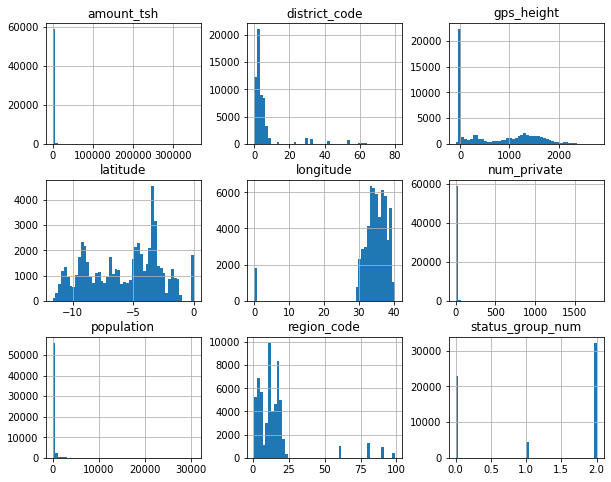

In [72]:
df_num.hist(bins=50, figsize=(10,8))
plt.show()

#### Visualize geographic data

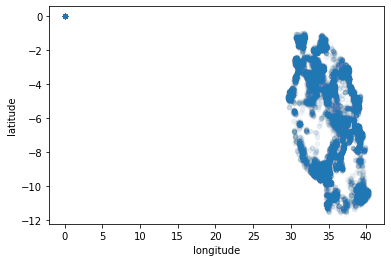

In [73]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.01)

Longitudes are centered around 30-40, and latitudes vary between 0 and -12.
It appears there are several outlier points with longitude and latitude of zero. (0, 0) does not fall within the bounds of Tanzania. Therefore, these longitudes and latitudes must be substituted in based on other metrics like region names/codes, district names/codes, etc.

In [74]:
long_0 = (df['longitude'] == 0)
lat_0 = (df['latitude'] == -0.00000002)
print('There are', df[long_0 & lat_0].shape[0], 'wells on latittude -0.00000002 and longitude 0. ')

There are 1812 wells on latittude -0.00000002 and longitude 0. 


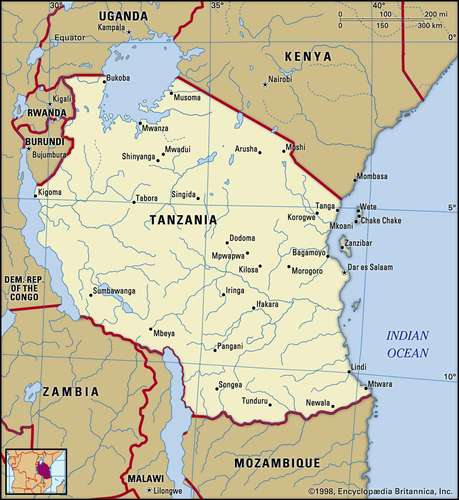

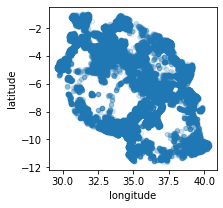

In [75]:
df_no_0 = df[~long_0 & ~lat_0]
df_no_0.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(3,3))
Image(filename='Tanzania-map.jpg', width = 150, height = 75)

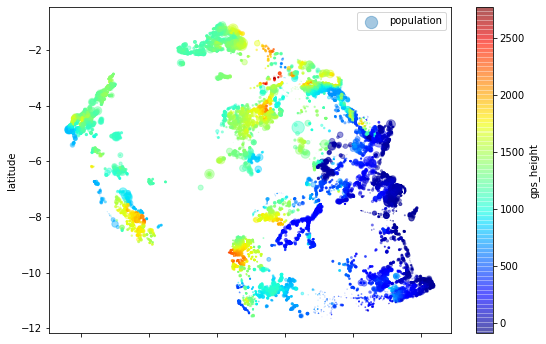

In [76]:
df_no_0.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
         s=df_no_0["population"]/100, label="population",
         c="gps_height", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(9,6)
     )
plt.legend()

*By using the gps_height attribute, we learn that waterpoints in the eastern regions of Tanzania are shorter than those in the north and western regions.*

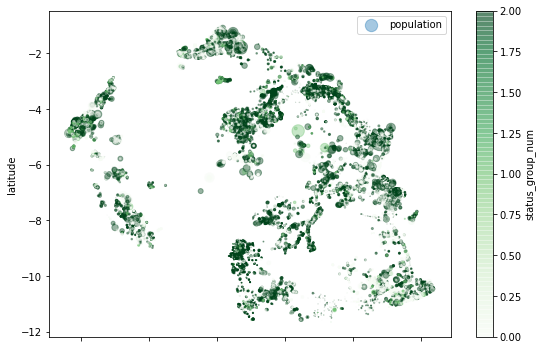

In [80]:
df_no_0.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
         s=df_no_0["population"]/100, label="population",
         c="status_group_num", cmap=plt.get_cmap("Greens"), colorbar=True, figsize=(9,6)
     )
plt.legend()

*It is hard to tell where the functional waterpoints are versus the non-functional ones.*

#### Sort variables by least to most types of values
- This will allow us to start looking at attributes in order of least to most value counts

In [25]:
df_nuniq = helpers.sort_by_nunique(df)

In [27]:
df_nuniq.head(10)

,attribute,count
18,public_meeting,2
21,permit,2
39,status_group,3
36,source_class,3
33,quantity_group,5
32,quantity,5
27,management_group,5
31,quality_group,6
38,waterpoint_type_group,6
35,source_type,7


#### Funder and installer:
- funder: who funded the well
- installer: organization that installed the well

In [94]:
print(df['funder'].nunique())
print(df['installer'].nunique())

1897
2145


In [ ]:
f = df[df['status_group'] == 'functional']
nf = df[df['status_group'] == 'non functional']
fnr = df[df['status_group'] == 'functional needs repair']

In [ ]:
class_lst = [f, nf, fnr]
class_dict = {'func': f, 'non-func': nf, 'func-not-work': fnr}

In [ ]:
def get_var_pcts_per_class(class_dict, var):
    """Returns a dataframe containing the percentage of each value of a variable in each class. """
    return_lst = []
    for k, d in class_dict.items():
        d_var = pd.DataFrame(d[var].value_counts() / d.shape[0] * 100).reset_index().rename(columns={var:str('pct_'+k),'index':var})
        return_lst.append(d_var)
    return_df = reduce(lambda left,right: pd.merge(left,right,on=[var], how='outer'), return_lst)
    return return_df

In [ ]:
funder_df = get_var_pcts_per_class(class_dict=class_dict, var='funder')

In [ ]:
f_funder = pd.DataFrame(f['funder'].value_counts() / f.shape[0] * 100).reset_index().rename(columns={'funder':'pct', 'index':'funder'})


#### Split into train and test (validation) sets

In [19]:
t_set, v_set = train_test_split(df, test_size=0.2, random_state=42)
print(len(t_set), "train +", len(v_set), "test (validation)")

47520 train + 11880 test (validation)


## Appendix

### Finding quasi-constant features

In [ ]:
import pandas as pd
import helper_functions as helpers

config = helpers.get_config('config.yaml')
parse_dts, remove_cols, data_types = helpers.get_config_columns(config['column_dtypes'])
training_values = pd.read_csv('training-values.csv', low_memory=False, 
                              parse_dates=parse_dts, usecols = lambda x: x not in remove_cols, 
                              dtype=data_types)
test_set_values = pd.read_csv('training-values.csv', low_memory=False, 
                              parse_dates=parse_dts, usecols = lambda x: x not in remove_cols, 
                              dtype=data_types)

In [ ]:
numeric_cols = config['column_dtypes']['float_cols'] + config['column_dtypes']['int_cols']
cols_to_keep = numeric_cols
df = training_values[numeric_cols].copy()

In [ ]:
from sklearn.feature_selection import VarianceThreshold
qconstant_filter = VarianceThreshold(threshold=0.1)
qconstant_filter.fit(df)
print(len(df.columns[qconstant_filter.get_support()]))

qconstant_columns = [column for column in df.columns
                    if column not in df.columns[qconstant_filter.get_support()]]

print(len(qconstant_columns))

### Finding correlated features

In [ ]:
correlation_matrix = df.corr()
correlated_features = set()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(correlated_features)

### Permutation importance
This form of determining feature importances is an alternative to the impurity-based Random Forest Feature Importance, which is known to inflate the importance of numerical attributes. 

In [ ]:
from sklearn.model_selection import train_test_split

X = training_values
y = test_set_values

num_cols = config['column_dtypes']['float_cols'] + config['column_dtypes']['int_cols']
cat_cols = config['column_dtypes']['str_cols']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Population of missing longitude/latitude values

After assessing different combinations of variables, this one of the most accurate ways to deduce the longitudes and latitudes of the waterpoints with missing coordinates, without manually searching for the village name on Google to acquire new data, which is not allowed in this:

- For missing waterpoints, take the average longitudes and latitudes from filled data of waterpoints with the **same basin and same region**. This strategy fills in coordinates for 1713 out of 1812 (about 95%) waterpoints. There may be other strategies that are better but this one results in a very low median variance (0.0988). The reason why it does not fill in all 100% is because not every basin+region combo has data to fill in the missing ones. 
- For the remaining 5% of waterpoints, I used the following combinations to fill them in, in the order listed below:
    - **funder == 'Hesawa'**** (variance among longitudes = 1.6293, populated 43 out of remaining 99 longitudes)
    - **basin == 'Lake Tanganyika' & wpt_name == 'Bombani'** (variance among longitudes = 0.0, populated 22 out of remaining 56 longitudes)
    - **basin == 'Lake Tanganyika' & scheme_name = 'Borehole'** (variance among longitudes = 0.0, populated 21 out of remaining 34 longitudes)
    - **region == 'Mwanza' & region_code == 19** (variance among longitudes = 0.1084, populated 13 out of remaining 13 longitudes)

#### Iteration 1: Fills 95% of missing waterpoint coordinates by joining first entry of each basin-region combo with missing rows.

In [452]:
def get_basin_region_combos(df, variance_column):
    """Returns variance of a column based on combinations of basin and region combos. """
    var_col_name = str(variance_column + '_var')
    basin_region_combo_vars = pd.DataFrame(columns={'basin', 'region', var_col_name})
    for basin in list(df['basin'].unique()):
        df_basin = df[df['basin'] == basin]
        for region in list(df['region'].unique()):
            df_basin_region = df_basin[df_basin['region'] == region]
            if df_basin_region.shape[0] == 0:
                continue
            basin_region_combo_vars = basin_region_combo_vars.append(
                {'basin': basin, 
                 'region': region, 
                 var_col_name: np.var(df_basin_region[[variance_column]]).values[0]}, 
                ignore_index=True)
    basin_region_combo_vars = basin_region_combo_vars[['basin', 'region', var_col_name]]
    basin_region_combo_vars.sort_values(by=var_col_name, ascending=False, inplace=True)
    return basin_region_combo_vars

In [455]:
longitude_vars = helpers.get_basin_region_combos(df=df, variance_column='longitude')
longitude_vars.head()

,basin,region,longitude_var
5,Lake Victoria,Shinyanga,277.56665039
6,Lake Victoria,Mwanza,197.38864136
13,Ruvuma / Southern Coast,Ruvuma,0.71413976
12,Ruvuma / Southern Coast,Mtwara,0.30397102
20,Internal,Arusha,0.30173212


In [456]:
latitude_vars = helpers.get_basin_region_combos(df=df, variance_column='latitude')
latitude_vars.head()

,basin,region,latitude_var
5,Lake Victoria,Shinyanga,2.66157913
6,Lake Victoria,Mwanza,1.32043505
25,Lake Tanganyika,Rukwa,1.11879373
45,Lake Rukwa,Rukwa,0.70393205
19,Internal,Dodoma,0.42373759


In [258]:
def check_basin_region_combos(df, coordinate):
    df_return = pd.DataFrame(columns=['basin', 'region', 'num_waterpoints', str(coordinate + '_variance')])
    for basin in list(df['basin'].unique()):
        f1 = (df['basin'] == basin)
        df_basin = df[f1]
        for region in list(df['region'].unique()):
            f2 = (df_basin['region'] == region)
            df_basin_region = df_basin[f2]
            if df_basin_region.shape[0] == 0:
                continue
            # print(''.join([basin + '__' + region]), np.var(df_basin_region[[coordinate]]))
            df_return = df_return.append({'basin': basin, 'region': region, 'num_waterpoints': df_basin_region.shape[0], str(coordinate + '_variance'): np.var(df_basin_region[[coordinate]]).values[0]}, ignore_index=True)
    df_return.sort_values(by=str(coordinate + '_variance'), ascending=False, inplace=True)
    return df_return

In [259]:
df_longitude_vars = check_basin_region_combos(df=df, coordinate='longitude')
df_longitude_vars.head()

,basin,region,num_waterpoints,longitude_variance
5,Lake Victoria,Shinyanga,2269,277.56665039
6,Lake Victoria,Mwanza,3003,197.38864136
13,Ruvuma / Southern Coast,Ruvuma,1307,0.71413976
12,Ruvuma / Southern Coast,Mtwara,1730,0.30397102
20,Internal,Arusha,1309,0.30173212


In [421]:
np.median(df_longitude_vars['longitude_variance'])

0.09876338019967079

Besides the waterpoints in the Lake Victoria + Shinyanga and Lake Victoria + Mwanza combos, the variance in the longitudes of the rest of the basin-region combos is well below 1, indicating that the longitudes of waterpoints with missing coordinates can be estimated based on the mean or median of longitudes in these combos. 

In [401]:
long_0 = (df['longitude'] == 0)
lat_0 = (df['latitude'] == -0.00000002)

df_not_null = df[~long_0 & ~lat_0]

In [402]:
combo_cols = ['basin', 'region']
merge_cols = ['basin', 'region', 'longitude', 'latitude']

df_nulls = df[long_0 & lat_0].copy().drop(['longitude', 'latitude'], axis=1)
df_filled = df_not_null.copy()[merge_cols].groupby(combo_cols)['longitude', 'latitude'].agg('mean').reset_index()
df_nulls_filled = pd.merge(df_nulls, df_filled, on=combo_cols, how='left')
print('Number of entries populated from Method 1 (basin, region):', df_nulls_filled['longitude'].value_counts().sum(), 'out of', df_nulls.shape[0])

Number of entries populated from Method 1 (basin, region): 1713 out of 1812


<ipython-input-402-efa027a3f3e3>:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [403]:
long_var_Hesawa = np.var(df_not_null[df_not_null['funder'] == 'Hesawa'][['longitude']]).values[0]
print('The longitudinal variance among all waterpoints funded by Hesawa is', long_var_Hesawa)

The longitudinal variance among all waterpoints funded by Hesawa is 1.6293185


In [404]:
combo_cols = ['funder']
merge_cols = ['funder', 'longitude', 'latitude']

df_nulls_2 = df_nulls_filled[df_nulls_filled['longitude'].isna()].copy().drop(['longitude', 'latitude'], axis=1)
df_filled_2 = df_not_null[df_not_null['funder'] == 'Hesawa'].copy()[merge_cols].groupby(combo_cols)['longitude', 'latitude'].agg('mean').reset_index()
df_nulls_2_filled = pd.merge(df_nulls_2, df_filled_2, on=combo_cols, how='left')
print('Number of entries populated from this method:', df_nulls_2_filled['longitude'].value_counts().sum(), 'out of', df_nulls_2.shape[0])
                                                                                                                                

Number of entries populated from this method: 43 out of 99


<ipython-input-404-6bca8c393823>:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [405]:
long_var_basin_wpt = np.var(df_not_null[(df_not_null['basin'] == 'Lake Tanganyika') & (df_not_null['wpt_name'] == 'Bombani')][['longitude']]).values[0]
print('The longitudinal variance among all waterpoints with basin = Lake Tanganyika and wpt_name = Bombani is', long_var_basin_wpt)

The longitudinal variance among all waterpoints with basin = Lake Tanganyika and wpt_name = Bombani is 0.0


In [406]:
combo_cols = ['basin', 'wpt_name']
merge_cols = ['basin', 'wpt_name', 'longitude', 'latitude']

df_nulls_3 = df_nulls_2_filled[df_nulls_2_filled['longitude'].isna()].copy().drop(['longitude', 'latitude'], axis=1)
df_filled_3 = df_not_null[df_not_null['basin'] == 'Lake Tanganyika'].copy()[merge_cols].groupby(combo_cols)['longitude', 'latitude'].agg('mean').reset_index()
df_nulls_3_filled = pd.merge(df_nulls_3, df_filled_3, on=combo_cols, how='left')
print('Number of entries populated from this method:', df_nulls_3_filled['longitude'].value_counts().sum(), 'out of', df_nulls_3.shape[0])
                                                                                                                                

Number of entries populated from this method: 22 out of 56


<ipython-input-406-ae918137c69e>:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [407]:
# scheme_name
long_var_scheme_name = np.var(df_not_null[df_not_null['scheme_name'] == 'Borehole'][['longitude']]).values[0]
print('The longitudinal variance among all waterpoints with scheme_name = Borehole is', long_var_basin_wpt)

The longitudinal variance among all waterpoints with scheme_name = Borehole is 0.0


In [408]:
combo_cols = ['basin', 'scheme_name']
merge_cols = ['basin', 'scheme_name', 'longitude', 'latitude']

df_nulls_4 = df_nulls_3_filled[df_nulls_3_filled['longitude'].isna()].copy().drop(['longitude', 'latitude'], axis=1)
df_filled_4 = df_not_null[(df_not_null['basin'] == 'Lake Tanganyika') & (df_not_null['scheme_name'] == 'Borehole')].copy()[merge_cols].groupby(combo_cols)['longitude', 'latitude'].agg('mean').reset_index()
df_nulls_4_filled = pd.merge(df_nulls_4, df_filled_4, on=combo_cols, how='left')
print('Number of entries populated from this method:', df_nulls_4_filled['longitude'].value_counts().sum(), 'out of', df_nulls_4.shape[0])
                                                                                                                                

Number of entries populated from this method: 21 out of 34


<ipython-input-408-e67a45e5b612>:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [410]:
filter_1 = (df_not_null['region'] == 'Mwanza')
filter_2 = (df_not_null['region_code'] == 19)

np.var(df_not_null[filter_1 & filter_2][['longitude']]).values[0]

0.1083827

In [412]:
combo_cols = ['region', 'region_code']
merge_cols = ['region', 'region_code', 'longitude', 'latitude']

df_nulls_5 = df_nulls_4_filled[df_nulls_4_filled['longitude'].isna()].copy().drop(['longitude', 'latitude'], axis=1)
df_filled_5 = df_not_null[(df_not_null['region'] == 'Mwanza') & (df_not_null['region_code'] == 19)].copy()[merge_cols].groupby(combo_cols)['longitude', 'latitude'].agg('mean').reset_index()
df_nulls_5_filled = pd.merge(df_nulls_5, df_filled_5, on=combo_cols, how='left')
print('Number of entries populated from this method:', df_nulls_5_filled['longitude'].value_counts().sum(), 'out of', df_nulls_5.shape[0])
                                                                                                                                

Number of entries populated from this method: 13 out of 13


<ipython-input-412-bf67e0f9e254>:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

